<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [3]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

<br><br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [4]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [5]:
df = getDF()
df

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,NaN,NaN,NaN,1.0,7.0,2.0,3.0,8.0
User_2,9.0,10.0,2.0,2.0,6.0,5.0,3.0,8.0
User_3,4.0,7.0,9.0,6.0,6.0,10.0,10.0,2.0
User_4,NaN,7.0,9.0,5.0,5.0,10.0,9.0,1.0
User_5,7.0,6.0,3.0,8.0,3.0,4.0,3.0,2.0
User_6,NaN,NaN,9.0,9.0,6.0,8.0,9.0,NaN
User_7,3.0,5.0,4.0,4.0,3.0,3.0,9.0,NaN
User_8,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0
User_9,9.0,9.0,NaN,8.0,3.0,3.0,1.0,NaN
User_10,9.0,8.0,10.0,9.0,3.0,4.0,2.0,1.0


<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [6]:
ratings = df.fillna(0).values
ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [7]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [8]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [9]:
#matriz de interação - original;

ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [10]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

array([[ 0.,  0.,  0.,  1.,  7.,  0.,  0.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  0.,  3.,  0.],
       [ 4.,  7.,  9.,  6.,  0., 10., 10.,  0.],
       [ 0.,  7.,  0.,  5.,  0., 10.,  9.,  1.],
       [ 7.,  6.,  0.,  8.,  0.,  4.,  3.,  2.],
       [ 0.,  0.,  0.,  0.,  6.,  8.,  9.,  0.],
       [ 0.,  5.,  4.,  4.,  3.,  3.,  0.,  0.],
       [10., 10., 10.,  0.,  2.,  2.,  2.,  0.],
       [ 0.,  9.,  0.,  8.,  3.,  3.,  0.,  0.],
       [ 0.,  0., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  0.,  0.],
       [ 0.,  2.,  4.,  1.,  8., 10., 10.,  0.],
       [ 1.,  4.,  1.,  3.,  0., 10.,  7.,  0.],
       [ 3.,  0.,  2.,  1.,  0., 10.,  0., 10.],
       [ 9.,  9.,  0., 10.,  4.,  2.,  0.,  0.]])

In [11]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

array([[ 0.,  0.,  0.,  0.,  0.,  2.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  8.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  0.,  2.],
       [ 0.,  0.,  9.,  0.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  9.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  2.],
       [ 9.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 9.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  8., 10.],
       [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  9.],
       [ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  8.],
       [ 0.,  3.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  8.,  0.,  0.,  0.,  0.,  1.]])

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [12]:
train, val = train_test_split(train, qtd = 2)

In [13]:
train

array([[ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.],
       [ 0., 10.,  2.,  0.,  6.,  0.,  3.,  0.],
       [ 4.,  7.,  0.,  6.,  0.,  0., 10.,  0.],
       [ 0.,  7.,  0.,  0.,  0.,  0.,  9.,  1.],
       [ 7.,  0.,  0.,  8.,  0.,  4.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  4.,  3.,  0.,  0.,  0.],
       [ 0., 10., 10.,  0.,  2.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  3.,  0.,  2.,  1.],
       [ 0.,  4.,  3.,  0.,  9.,  9.,  0.,  0.],
       [ 0.,  2.,  4.,  1.,  8.,  0.,  0.,  0.],
       [ 1.,  0.,  1.,  0.,  0., 10.,  7.,  0.],
       [ 3.,  0.,  2.,  0.,  0.,  0.,  0., 10.],
       [ 9.,  0.,  0.,  0.,  4.,  2.,  0.,  0.]])

In [14]:
val

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  8.],
       [ 9.,  0.,  0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  5.,  0., 10.,  0.,  0.],
       [ 0.,  6.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  8.,  9.,  0.],
       [ 0.,  0.,  4.,  0.,  0.,  3.,  0.,  0.],
       [10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  9.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  9.,  0.,  4.,  0.,  0.],
       [ 4.,  0.,  0.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 10., 10.,  0.],
       [ 0.,  4.,  0.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0., 10.,  0.,  0.],
       [ 0.,  9.,  0., 10.,  0.,  0.,  0.,  0.]])

In [15]:
test

array([[ 0.,  0.,  0.,  0.,  0.,  2.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  8.],
       [ 0.,  0.,  0.,  0.,  6.,  0.,  0.,  2.],
       [ 0.,  0.,  9.,  0.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  3.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  9.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  0.,  0.,  2.],
       [ 9.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 9.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  8., 10.],
       [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  9.],
       [ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  8.],
       [ 0.,  3.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  8.,  0.,  0.,  0.,  0.,  1.]])

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [16]:
train + val + test

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [17]:
(train + val + test) == ratings

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [18]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [19]:
fat.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [20]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,4.20,6.34,4.25,5.01,6.88,7.95,5.81,3.84
User_2,6.05,9.51,2.31,8.15,5.75,4.31,3.22,6.80
User_3,3.87,6.99,1.97,6.05,8.23,11.29,9.45,4.81
User_4,4.35,6.85,3.25,5.89,5.86,9.85,8.72,1.09
User_5,6.95,9.42,5.20,7.69,4.31,3.92,3.06,4.36
User_6,3.76,5.65,3.71,4.42,5.91,5.64,3.65,3.99
User_7,3.63,4.94,3.23,3.93,2.96,2.76,1.91,2.22
User_8,8.64,9.74,9.69,7.28,2.28,1.87,1.16,1.95
User_9,6.05,8.86,2.41,7.75,3.05,3.94,4.13,3.45
User_10,7.32,8.03,9.60,5.75,3.00,3.25,1.98,1.00


<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [21]:
pd.DataFrame(val, columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
User_2,9.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
User_3,0.0,0.0,9.0,0.0,0.0,10.0,0.0,0.0
User_4,0.0,0.0,0.0,5.0,0.0,10.0,0.0,0.0
User_5,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0
User_6,0.0,0.0,0.0,0.0,0.0,8.0,9.0,0.0
User_7,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0
User_8,10.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
User_9,0.0,9.0,0.0,0.0,0.0,3.0,0.0,0.0
User_10,0.0,0.0,0.0,9.0,0.0,4.0,0.0,0.0


<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

In [22]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Primeiro passo: trocar todos os dados faltantes por 0 e tranformar nosso dataset num array, porém vamos fazer uma rápida análise de quantos dados faltantes temos no total.

In [23]:
nulo = R.isnull().sum().sum()

nulo

20471

In [24]:
# em termos de porcentagem:

a = R.isnull().sum().sum()/(R.shape[0]*R.shape[1])

a

0.697241144414169

Quase 70% dos dados são nulos, precisamos de um baixo erro para preencher esses dados da melhor maneira possível. Agora sim, vamos trocar os dados faltantes por 0.

In [25]:
ratings_ex = R.fillna(0).values

In [26]:
ratings_ex

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

#### Segundo passo: Dividir os dados em dados de treino, validação e teste usando a função dada no exercício.

In [27]:
treino, teste = train_test_split(ratings_ex, 2)

In [28]:
treino

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [29]:
teste

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
treino, valid = train_test_split(treino, 2)

In [31]:
treino

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [32]:
valid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
teste

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Antes de criar nosso GridSeach, vamos fazer uma fatoração nos nosso dados com parâmetros fixados, entre eles, 500 passos, depois disso, analisaremos o gráfico de erro, e assim poderemos ter uma noção intuitiva da quantidade máxima de passos que devemos escolher para fazer o GridSeach.

In [34]:
fato = MatrixFactorization(dataframe = pd.DataFrame(treino, columns = R.columns, index = R.index), 
                          K = 10, steps = 200, alpha = 0.0002, beta = 0.2)

In [35]:
fato.fit()

Fatoração concluída. Tempo aproximado: 2 minuto(s).


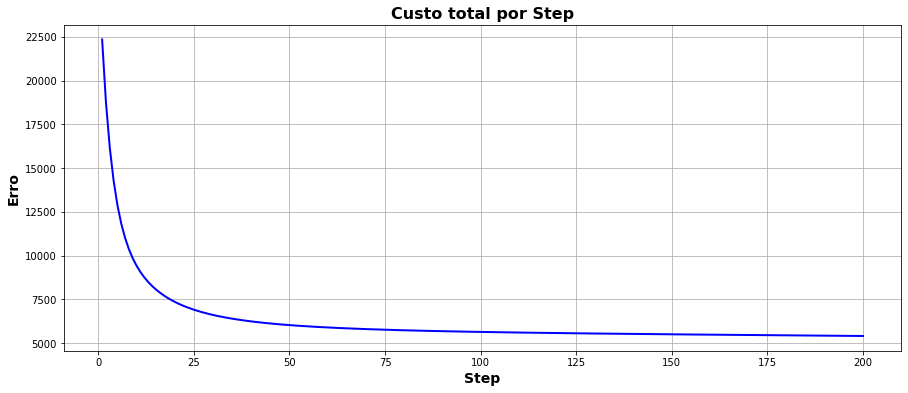

In [36]:
fato.print_MSE_steps()

Agora que temos uma noção da quantidade de passos que precisaremos (entre 150 e 300), vamos criar uma função parecida com o MSE, onde vai nos retornar o erro quando compararmos nossos dados de treino, com os de validação e teste

In [37]:
def mse_error(y_pred,y_true):
    
    R = y_true
    Rp = y_pred
    
    lista_erro = []
    
    mse_total_step = 0

    for i in range(len(R)):
        for j in range(len(R[i])):
                   
            if R[i][j] > 0:
                eij = R[i][j] - Rp[i][j]
                    
                mse_total_step += (eij)**2
                        
                        
    lista_erro.append(mse_total_step)
    
    return lista_erro[-1]

Iremos fazer nosso GridSeach por partes, inicialmente fixaremos:

__Alpha = 0.0001__

__Beta = 0.1__

__Número de Passos = 200__

E iremos variar a dimensão do espaço latente K.

In [38]:
for k in [3,5,10,40,60]:
                
    fato = MatrixFactorization(dataframe = pd.DataFrame(treino, columns = R.columns, index = R.index), 
                          K = k, steps = 200, alpha = 0.001, beta = 0.1)
                
    fato.fit()
    
    mse = mse_error(y_pred = fato.predict(), y_true = valid)
    mse1 = mse_error(y_pred = fato.predict(), y_true = teste)
                
    print('\nParâmetros utilidados: alpha = 0.001, beta = 0.1, Steps = 200, K =  ', k)
    print('Erro em dados de treino: ', fato.lista_erro_step[-1], '\nErro em dados de Validação: ', mse, 
          '\nErro em dados de teste: ', mse1, '\n')

Fatoração concluída. Tempo aproximado: 1 minuto(s).

Parâmetros utilidados: alpha = 0.001, beta = 0.1, Steps = 200, K =   3
Erro em dados de treino:  4817.589520296703 
Erro em dados de Validação:  585.6997971126938 
Erro em dados de teste:  699.238672530255 

Fatoração concluída. Tempo aproximado: 1 minuto(s).

Parâmetros utilidados: alpha = 0.001, beta = 0.1, Steps = 200, K =   5
Erro em dados de treino:  4173.664869073066 
Erro em dados de Validação:  624.3441194051841 
Erro em dados de teste:  735.8610042119882 

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha = 0.001, beta = 0.1, Steps = 200, K =   10
Erro em dados de treino:  3061.7009805091134 
Erro em dados de Validação:  663.595914890245 
Erro em dados de teste:  751.5796188878983 

Fatoração concluída. Tempo aproximado: 6 minuto(s).

Parâmetros utilidados: alpha = 0.001, beta = 0.1, Steps = 200, K =   40
Erro em dados de treino:  1130.6351190555147 
Erro em dados de Validação:  658.5688181907

A primeira observação que devemos fazer é que a diferença dos erros do dado de treino para validação e teste se da pelo fato de que nos dados de validação e de teste, somente duas das colunas são não nulas, e consequêntemente ao fazer o somatório da nossa função mse_error, esse número vai ser menor do que o erro encontrado pela fatoração nos dados de treino.

Outra coisa que devemos obserar é que minimizar o erro nos dados de treino é bom, porém os dados 'desconhecidos' são os dados de validação e de teste, portanto, não adianta ter um erro muito baixo no dados de treino, se esse erro aumenta nos dados de validação e de teste, pois assim, temos uma chance mais alta de overfiting.

Tendo em vista essas observações, vamos escolhar K = 10 para ser a dimensão do nosso espaço latente, pois nele temos um baixo erro nos dados de treino e erros mais baixos nos dados de validação e teste comparados com K = 40 e 60.\

### Agora fixando k = 10, vamos fazer a variação no alpha e ver os resultados.

In [40]:
for alpha in np.arange(0.001,0.007, 0.001):
                
    fato = MatrixFactorization(dataframe = pd.DataFrame(treino, columns = R.columns, index = R.index), 
                          K = 10, steps = 200, alpha = alpha, beta = 0.1)
                
    fato.fit()
    
    mse = mse_error(y_pred = fato.predict(), y_true = valid)
    mse1 = mse_error(y_pred = fato.predict(), y_true = teste)
                
    print('\nParâmetros utilidados: alpha = ', alpha, 'beta = 0.1, Steps = 200, K =  10')
    print('Erro em dados de treino: ', fato.lista_erro_step[-1], '\nErro em dados de Validação: ', mse, 
          '\nErro em dados de teste: ', mse1, '\n')

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha =  0.001 beta = 0.1, Steps = 200, K =  10
Erro em dados de treino:  3176.0052167809213 
Erro em dados de Validação:  624.3835056932573 
Erro em dados de teste:  763.5105183001924 

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha =  0.002 beta = 0.1, Steps = 200, K =  10
Erro em dados de treino:  2445.5642565119197 
Erro em dados de Validação:  715.5716045826306 
Erro em dados de teste:  782.7351340522534 

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha =  0.003 beta = 0.1, Steps = 200, K =  10
Erro em dados de treino:  2261.3706782762515 
Erro em dados de Validação:  739.8828247225316 
Erro em dados de teste:  770.192385603037 

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha =  0.004 beta = 0.1, Steps = 200, K =  10
Erro em dados de treino:  2166.876886278131 
Erro em dados de Validação:  791.1198056137

Podemos notar que de 0.003 para cima, o erro nos dados de treino pouco mudou, enquanto nos dados de  validação e teste, aumentaram.

Entre 0.001 e 0.002, pela diferença entre os valores, afim de evitar algum possível overfiting, vamos escolher alpha = 0.002.

Agora já temos fixados:

__K = 10__

__Alpha = 0.001__

Vamos então encontrar possíveis valores para Beta.

In [41]:
for beta in np.arange(0.1,0.7, 0.1):
                
    fato = MatrixFactorization(dataframe = pd.DataFrame(treino, columns = R.columns, index = R.index), 
                          K = 10, steps = 200, alpha = 0.002, beta = beta)
                
    fato.fit()
    
    mse = mse_error(y_pred = fato.predict(), y_true = valid)
    mse1 = mse_error(y_pred = fato.predict(), y_true = teste)
                
    print('\nParâmetros utilidados: alpha = 0.002', 'beta = ' , beta, 'Steps = 200, K =  10')
    print('Erro em dados de treino: ', fato.lista_erro_step[-1], '\nErro em dados de Validação: ', mse, 
          '\nErro em dados de teste: ', mse1, '\n')

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta =  0.1 Steps = 200, K =  10
Erro em dados de treino:  2456.0493110925017 
Erro em dados de Validação:  670.7596293375715 
Erro em dados de teste:  767.9555217045585 

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta =  0.2 Steps = 200, K =  10
Erro em dados de treino:  3089.8402342312083 
Erro em dados de Validação:  623.6663162378925 
Erro em dados de teste:  702.1543214652692 

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta =  0.30000000000000004 Steps = 200, K =  10
Erro em dados de treino:  4075.882486460002 
Erro em dados de Validação:  574.1422170500161 
Erro em dados de teste:  679.9905284512436 

Fatoração concluída. Tempo aproximado: 3 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta =  0.4 Steps = 200, K =  10
Erro em dados de treino:  5024.664150580431 
Erro em dados de Validação:  58

Temos algo bem intessante aqui, até beta = 0.3, apesar do erro em dados de treino ter aumentado, o erro nos dados de validação e teste, abaixaram, vamos escolher um meio termo para nossa regularização, beta = 0.2

Para finalizar nosso GridSearch, vamos fazer uma variação no número de passos.

In [42]:
for steps in np.arange(50,350,50):
                
    fato = MatrixFactorization(dataframe = pd.DataFrame(treino, columns = R.columns, index = R.index), 
                          K = 10, steps = steps, alpha = 0.002, beta = 0.2)
                
    fato.fit()
    
    mse = mse_error(y_pred = fato.predict(), y_true = valid)
    mse1 = mse_error(y_pred = fato.predict(), y_true = teste)
                
    print('\nParâmetros utilidados: alpha = 0.002', 'beta = 0.2, Steps =', steps, ' K =  10')
    print('Erro em dados de treino: ', fato.lista_erro_step[-1], '\nErro em dados de Validação: ', mse, 
          '\nErro em dados de teste: ', mse1, '\n')

Fatoração concluída. Tempo aproximado: 1 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta = 0.2, Steps = 50  K =  10
Erro em dados de treino:  4986.42889663429 
Erro em dados de Validação:  603.8952714463453 
Erro em dados de teste:  712.5550044957585 

Fatoração concluída. Tempo aproximado: 1 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta = 0.2, Steps = 100  K =  10
Erro em dados de treino:  3845.5549759178625 
Erro em dados de Validação:  618.9722635083359 
Erro em dados de teste:  685.6835481766689 

Fatoração concluída. Tempo aproximado: 2 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta = 0.2, Steps = 150  K =  10
Erro em dados de treino:  3359.4517630588907 
Erro em dados de Validação:  590.2490967737846 
Erro em dados de teste:  748.5543374339212 

Fatoração concluída. Tempo aproximado: 3 minuto(s).

Parâmetros utilidados: alpha = 0.002 beta = 0.2, Steps = 200  K =  10
Erro em dados de treino:  3060.541234368548 
Erro em dados de Validação:  621.3233110892327 
E

Finalizamos então escolhendo nosso último parâmetro, número de passos = 250.

Mais uma observação que podemos fazer é que poderiamos ter colocado todas essas variações de parâmetros em um único código, iria demorar mais tempo e teriamos mais combinações para analisar, mas fazendo assim passo a passo, conseguimos entender o que ta acontecendo e conseguimos bons resultados.

Vamos finalizar então criando nosso objeto com os parâmetros escolhidos para depois fitar e aplicar no nosso dataset original

In [43]:
fato1 = MatrixFactorization(dataframe = pd.DataFrame(ratings_ex, columns = R.columns, index = R.index), 
                          K = 10, steps = 250, alpha = 0.002, beta = 0.2)
                

fato1.fit()

Fatoração concluída. Tempo aproximado: 3 minuto(s).


In [44]:
fato1.lista_erro_step[-1]

3814.7880196879023

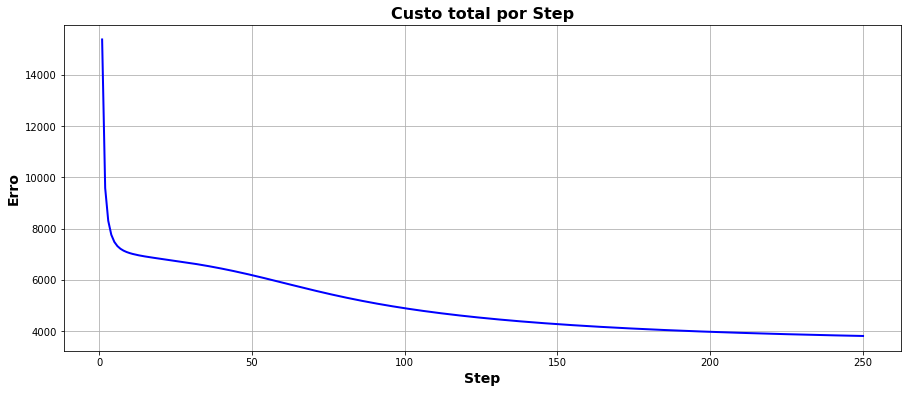

In [45]:
fato1.print_MSE_steps()

Finalizamos aqui com um ótimo resultado, se dividirmos o erro pela quantidade de registros não nulos nos obtemos:

In [46]:
media_erro = fato1.lista_erro_step[-1]/(R.shape[0]*R.shape[1]-nulo)

media_erro

0.42915828773629233

Ou seja, o quadrado da diferença dos valores originais para os preditos pela matriz de fatoração é em média de 0.43, um número muito baixo.

Para conferir o quão próximo chegamos, podemos comparar uma linha das duas tabelas.

In [55]:
df = pd.DataFrame(fato1.predict(), columns = R.columns, index = R.index)

df.iloc[:1,:10]

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10
User_0,3.633915,2.956317,3.542881,3.312958,3.039617,3.817698,3.707119,3.480896,4.242296,3.758695


In [56]:
R.iloc[:1,:10]

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0


Podemos ver que temos sim algum erro mais notável, como no Filme_8, porem a grande maioria ta com esses muito pequenos, se as notas forem arredondadas (já que teoricamente as notas são sempre números natuais), teriamos um grande número de acertos.

Então muito provavelmente, pela maneira que escolhemos os parâmetros, de maneira que não 'overfitasse' nos dados de validação e de teste, vamos ter excelentes resultados para o sistema de recomendação.

Finalizamos aqui o exercício do último módulo.